# Consistent Bayes: Examples from the Paper
---

Copyright 2018 Michael Pilosov

Based on work done by ... 

### Import Libraries
_tested with python 3.6 on 02/11/18_

In [2]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
# %matplotlib inline
# %matplotlib notebook
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 8, 5
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *

# import numpy as np
from scipy.integrate import odeint
# import matplotlib.pyplot as plt
import progressbar


# Example Summary

---

The second example is defined by the model for a harmonic oscillator given by the initial value problem  

\begin{equation}
	\begin{cases}
		\frac{d^2u}{dt^2} &= -\lambda_2^2 u, \ t>0, \\
		u(0) &= \lambda_1. 
	\end{cases}
\end{equation}

Choosing a particular parameter $\lambda=(\lambda_1,\lambda_2)\in\Lambda\subset[-1,1]\times\mathbb{R}^+$ corresponds to fixing an initial condition, $\lambda_1\in[-1,1]$, and frequency of oscillation, $\lambda_2$, where we again assume that $\lambda_2>0$.

The solution to the above is
\begin{equation}
	u(t) = \cos(\lambda_2 t + \arccos(\lambda_1)).
\end{equation}

---
## Define Functions

In [154]:
##### FIXED PARAMETERS #####

num_observations = 50 # how many observations are you able to make over the year?
max_time = 1
####

def SSE_generator(model, obs_data, sigma=1):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        predictions = model(inputs)
        assert predictions.shape[1] == len(obs_data)
        residuals = predictions - obs_data
        QoI = np.sum( (residuals/sigma)**2, axis=1 )
        return QoI
    return QoI_fun

# The model of the harmonic oscillator=
def makemodel(t):
    def model(lam = np.array([[0, 1]]) ):
#         return np.cos(lam[:,1]*t + np.arccos(lam[:,0]) )
        QoI = np.cos(np.outer(lam[:,1],t) + np.arccos(lam[:,0]).reshape(len(lam[:,0]),1) )
        if QoI.shape[0] == 1:
            return QoI.ravel() # this allows support for simpler 1D plotting.
        else:
            return QoI
    return model

No handles with labels found to put in legend.


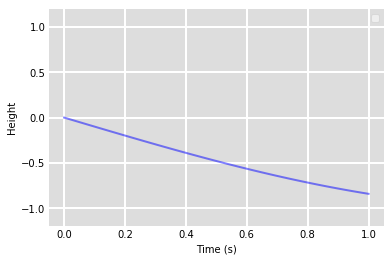

In [155]:
t = np.linspace(0, max_time, num_observations)
model = makemodel(t)
u = model()

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, u, 'b', alpha=0.5, lw=2)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Height')

ax.set_ylim(-1.2,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Get a sense of the variation 



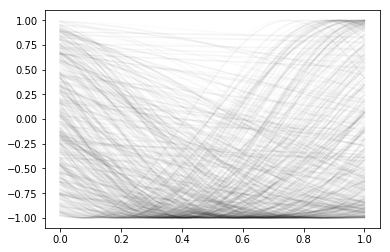

In [188]:
n = 500
lam = np.random.random(size=(n,2))
lam[:,0] = 2*lam[:,0] - 1.0
lam[:,1] = 5*lam[:,1]
u = model(lam)
# Plotting the default IR results from the epidemic_IR function.
for i in range(n):
    plt.plot(t, u[i,:], c='k', alpha=0.05*i/n) # I


--- 

# Define Prior Measure $P_\Lambda$


In [168]:
input_dim = 2 # Specify input space dimension (n)
num_samples = int(1E4) # number of input samples (N)
s_set = sample.sample_set(size=(num_samples, input_dim))

s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -1, 'scale': 2}, dim=0) # initial condition
s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 2}, dim=1) # frequency
s_set.generate_samples()

lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

In [169]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
                    N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
                    eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
                    view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
                    view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [179]:
u_true = model() # t as a subscript stands for "truth"
sd = 0.1/6
obs_data = u_true + np.random.randn(int(num_observations))*sd
PtO_fun = SSE_generator(model, obs_data, sd)

In [180]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples

# This is how we handle trying to infer the dimension based on what the map put out.
# You can delete this once you are certain your model is correctly defined.
try:
    output_dim = D.shape[1] # if your function was coded correctly, you should have an (n, d) data space.
except IndexError:
    print(Warning("Warning: Your map might be returning the wrong dimensional data."))
    try:
       output_dim = D.shape[0] 
    except IndexError:
        print(Warning("Warning: Guessing it's 1-dimensional."))
        output_dim = 1
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

dimensions :  lambda = (10000, 2)   D = (10000, 1)


# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [181]:
# Interactive Marginal Visualization
p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

In [182]:
# pf_dist.kde_object.set_bandwidth(1E-10)
# %matplotlib inline

In [183]:
widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=10000, min = 100, max=10000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=10000, continuous_update=False, description='N', max=10000, min=100, step=100), Text(value='brown', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

# Define Observed Probability Measure $P_\mathcal{D}$

In [184]:
p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)

obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='wine', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [185]:
p_set.set_ratio()
eta_r = p_set.ratio
solve.problem(p_set)

In [186]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 6 = 0.06%


## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


In [187]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept+1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=3, continuous_update=False, description='N', max=7, min=2), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

In [ ]:
widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

## Pushforward of Posterior:

In [ ]:
widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


## Verify our parametric test statistics.
Let's see if the pushforward of the posterior results in a sample mean and standard deviation that are close to the observed.

In [ ]:
# [np.mean(D[accept_inds,:]), np.std(D[accept_inds,:])]

In [ ]:
# [p_set.observed_dist.mean(), p_set.observed_dist.std()]

Now go back to the [Sampling Section](#Sample-from-Prior) and change the distribution on the prior or choose another example problem.